In [1]:
import numpy as np
import torch

from skimage.data import shepp_logan_phantom
from skimage.transform import rescale

from utils.io import read_object
from utils.proj import slice_2D, slice_3D
from utils.warp import warp_2D

import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

### Fourier Slice Theorem
#### 2D image demo

In [2]:
# load image data (spatial domain)
H = W = 256
image_sd = shepp_logan_phantom()
image_sd = rescale(image_sd, scale=H/400, mode='reflect', channel_axis=None)
image_sd = torch.Tensor(image_sd).to(device)

# frequency domain
image_fd = torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(image_sd)))
# split real and imaginary part
image_fd_real = torch.view_as_real(image_fd).permute(2,0,1).contiguous().unsqueeze(0)

def R_2D(thetas):
    """ thetas shape: [N], from 0 to 2pi
    """
    N = thetas.shape[0]
    cos_a = torch.cos(thetas).unsqueeze(1)
    sin_a = torch.sin(thetas).unsqueeze(1)
    R = torch.cat((cos_a, -sin_a, sin_a, cos_a), 1).resize(N, 2, 2)
    return R

angle = 45
R = R_2D(torch.deg2rad(torch.Tensor([angle]))).to(device)

image_sd_rotated = warp_2D(image_sd.unsqueeze(0).unsqueeze(0), R, mode='linear')
image_fd_rotated = warp_2D(image_fd, R, mode='linear')

projection_fd = slice_2D(image_fd_real, R, 'lanczos')
projection_fd = torch.view_as_complex(projection_fd.squeeze(0).permute(1,0).contiguous())
projection_sd = torch.fft.fftshift(torch.fft.ifft(torch.fft.ifftshift(projection_fd)))

# integral along horison
radon_sd = image_sd_rotated.squeeze(0).squeeze(0).sum(1)
radon_fd = torch.fft.fftshift(torch.fft.fft(torch.fft.ifftshift(radon_sd)))

/home/yuanwei/anaconda3/envs/smoke-env/lib/python3.9/site-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


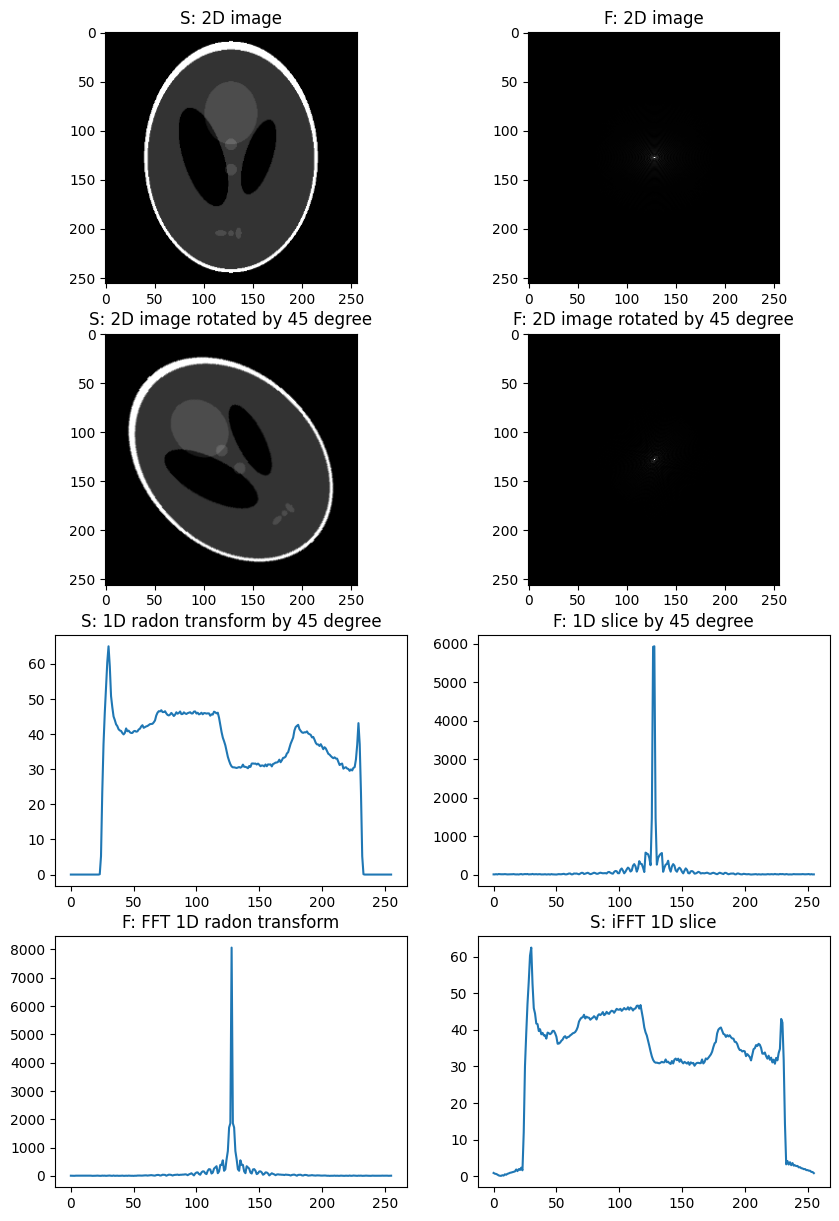

In [3]:
image_sd = image_sd.cpu()
image_fd = image_fd.cpu()
image_sd_rotated = image_sd_rotated.squeeze(0).squeeze(0).cpu()
image_fd_rotated = image_fd_rotated.squeeze(0).squeeze(0).cpu()
radon_sd = radon_sd.cpu()
radon_fd = radon_fd.cpu()
projection_fd = projection_fd.cpu()
projection_sd = projection_sd.cpu()

fig, axes = plt.subplots(4, 2, figsize=(10, 15))
ax = axes.ravel()

ax[0].set_title('S: 2D image')
ax[0].imshow(image_sd, cmap=plt.cm.gray)

ax[1].set_title('F: 2D image')
ax[1].imshow(torch.abs(image_fd), cmap=plt.cm.gray)

ax[2].set_title('S: 2D image rotated by {} degree'.format(angle))
ax[2].imshow(image_sd_rotated, cmap=plt.cm.gray)

ax[3].set_title('F: 2D image rotated by {} degree'.format(angle))
ax[3].imshow(torch.abs(image_fd_rotated), cmap=plt.cm.gray)

ax[4].set_title('S: 1D radon transform by {} degree'.format(angle))
ax[4].plot(radon_sd)

ax[5].set_title('F: 1D slice by {} degree'.format(angle))
ax[5].plot(torch.abs(projection_fd))

ax[6].set_title('F: FFT 1D radon transform')
ax[6].plot(torch.abs(radon_fd))

ax[7].set_title('S: iFFT 1D slice')
ax[7].plot(torch.abs(projection_sd))

The first colume is radon transform in the spatial domain: 
rotate the image and do `sum(1)`.
The second colume is slicing in the frequency domain.

The last row does FFT and iFFT to prove that the Fourier Slice Theorem works.

#### 3D object demo

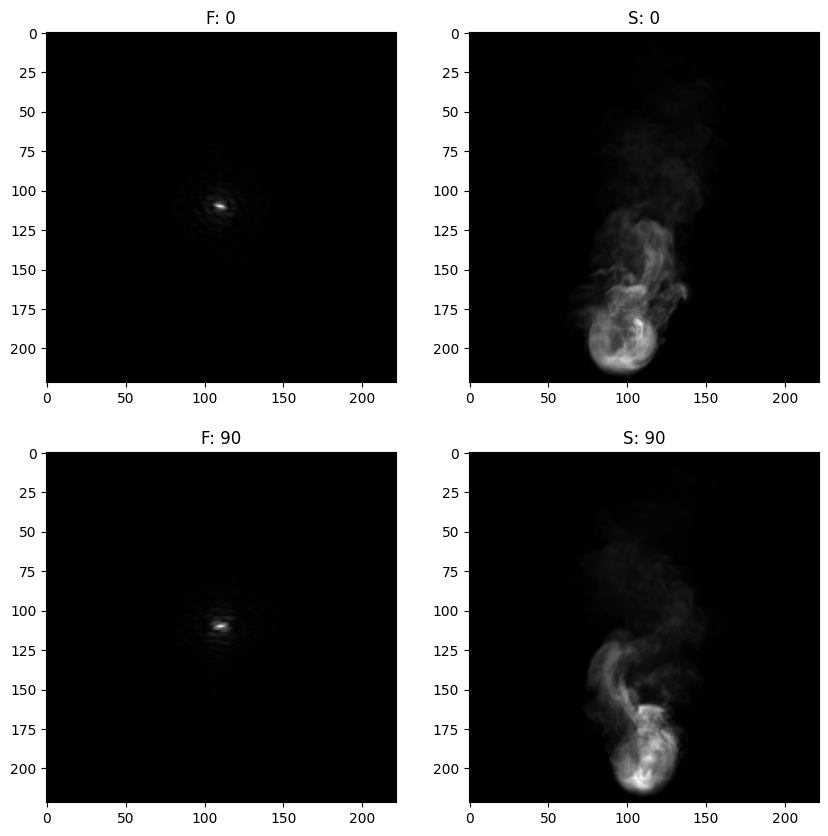

In [4]:
smoke_sd = read_object('./data/smoke.csv')

smoke_fd = torch.view_as_real(torch.fft.fftshift(torch.fft.fftn( \
           torch.fft.ifftshift(smoke_sd)))) \
           .permute(3,0,1,2).contiguous().unsqueeze(0)

def R_z(thetas):
    """ 
    thetas shape: [N], from 0 to 2pi
    """
    device = thetas.device

    N = thetas.shape[0]
    cos_a, sin_a = torch.cos(thetas).unsqueeze(1), torch.sin(thetas).unsqueeze(1)
    zero = torch.zeros(cos_a.shape).to(device)
    one = torch.ones(cos_a.shape).to(device)
    R = torch.cat((cos_a, -sin_a, zero, sin_a, cos_a, zero, zero, zero, one), 1) \
        .resize(N, 3, 3)

    return R

def convert_xy(image):
    """
    Convert image's xy so that it can be draw by plt
    """
    if image.ndim == 2:
        image = image.unsqueeze(0)
    return torch.flip(image, [1, 2]).permute(0,2,1)

angle = [0, 90]
N = len(angle)
R = R_z(torch.deg2rad(torch.Tensor(angle)))

smoke_fd = smoke_fd.repeat(N,1,1,1,1)
projection_fd = slice_3D(smoke_fd, R)

projection_fd = torch.view_as_complex(projection_fd.permute(0,2,3,1).contiguous())
projection_fd = convert_xy(projection_fd)
projection_sd = torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(projection_fd)))

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ax = axes.ravel()

ax[0].set_title('F: {}'.format(angle[0]))
ax[0].imshow(torch.abs(projection_fd[0]), cmap=plt.cm.gray)

ax[1].set_title('S: {}'.format(angle[0]))
ax[1].imshow(torch.abs(projection_sd[0]), cmap=plt.cm.gray)

ax[2].set_title('F: {}'.format(angle[1]))
ax[2].imshow(torch.abs(projection_fd[1]), cmap=plt.cm.gray)

ax[3].set_title('S: {}'.format(angle[1]))
ax[3].imshow(torch.abs(projection_sd[1]), cmap=plt.cm.gray)

This demo shows slicing in 3D object. It also accepts any `3 x 3` rotation matrix to represent slicing direction.